In [8]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [3]:
class GradCAM:
    def __init__(self, model, last_conv_layer_name):
        self.model = model
        self.last_conv_layer_name = last_conv_layer_name
        self.grad_model = tf.keras.models.Model(
            [self.model.inputs],
            [self.model.get_layer(last_conv_layer_name).output, self.model.output]
        )

    def compute_heatmap(self, image_array, class_index):
        with tf.GradientTape() as tape:
            last_conv_layer_output, preds = self.grad_model(image_array)
            class_channel = preds[:, class_index]

        grads = tape.gradient(class_channel, last_conv_layer_output)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

        last_conv_layer_output = last_conv_layer_output[0]
        heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)

        heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
        return heatmap.numpy()

In [4]:
def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array)

In [14]:
def generate_and_save_gradcam(image_path, model, last_conv_layer_name, pred_index=None):
    img_array = preprocess_image(image_path)
    
    preds = model.predict(img_array)
    if pred_index is None:
        pred_index = tf.argmax(preds[0])
    
    grad_cam = GradCAM(model, last_conv_layer_name)
    heatmap = grad_cam.compute_heatmap(img_array, pred_index)
    
    img = image.load_img(image_path)
    img = image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)
    jet = plt.cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * 0.4 + img
    # Convert RGB to BGR for cv2 compatibility
    superimposed_img_bgr = cv2.cvtColor(superimposed_img, cv2.COLOR_RGB2BGR)
    cv2.imwrite('./artifacts/gradcam_output.jpg', superimposed_img_bgr)
    superimposed_img = image.array_to_img(superimposed_img)


    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image.array_to_img(img))
    plt.title("Original Image")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.title("Grad-CAM")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


C:\Users\enay9\AppData\Local\Temp\ipykernel_21404\2736780595.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = plt.cm.get_cmap("jet")


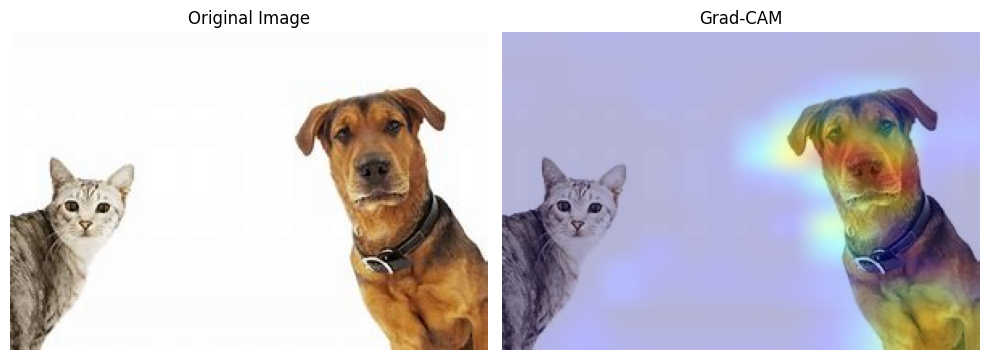

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
Predicted: Rhodesian_ridgeback


In [15]:
# Load pre-trained VGG16 model
model = VGG16(weights='imagenet')

# Specify the last convolutional layer name
last_conv_layer_name = "block5_conv3"

# Generate and save Grad-CAM
image_path = "./artifacts/cat_dog.jpeg"  # Replace with your image path
generate_and_save_gradcam(image_path, model, last_conv_layer_name)

# Print predicted class
img_array = preprocess_image(image_path)
preds = model.predict(img_array)
print('Predicted:', decode_predictions(preds, top=1)[0][0][1])

----------------

In [9]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

class GradCAM:
    def __init__(self, model, last_conv_layer_name):
        self.model = model
        self.last_conv_layer_name = last_conv_layer_name
        self.grad_model = tf.keras.models.Model(
            [self.model.inputs],
            [self.model.get_layer(last_conv_layer_name).output, self.model.output]
        )

    def compute_heatmap(self, image_array, class_index):
        with tf.GradientTape() as tape:
            last_conv_layer_output, preds = self.grad_model(image_array)
            class_channel = preds[:, class_index]

        grads = tape.gradient(class_channel, last_conv_layer_output)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

        last_conv_layer_output = last_conv_layer_output[0]
        heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)

        heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
        return heatmap.numpy()

def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array)

def generate_and_save_gradcam(image_path, model, last_conv_layer_name, pred_index=None):
    img_array = preprocess_image(image_path)
    
    preds = model.predict(img_array)
    if pred_index is None:
        pred_index = tf.argmax(preds[0])
    
    grad_cam = GradCAM(model, last_conv_layer_name)
    heatmap = grad_cam.compute_heatmap(img_array, pred_index)
    
    img = image.load_img(image_path)
    img = image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)
    jet = plt.cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * 0.4 + img
    superimposed_img = image.array_to_img(superimposed_img)
    return superimposed_img

def save_imposed_image(save_path,superimposed_img):
    # Check if superimposed_img is not a numpy array
    if not isinstance(superimposed_img, np.ndarray):
        # Convert to numpy array if it's not
        superimposed_img = np.array(superimposed_img)

    if superimposed_img.dtype != np.uint8:
        superimposed_img = np.uint8(superimposed_img)
        
    # Convert RGB to BGR for cv2 compatibility
    superimposed_img_bgr = cv2.cvtColor(superimposed_img, cv2.COLOR_RGB2BGR)
    if save_path is None:
        save_path = './artifacts/gradcam_output.jpg'
    cv2.imwrite(save_path, superimposed_img_bgr)
    


def show(image_path,superimposed_img):
    img = image.load_img(image_path)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image.array_to_img(img))
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.title("Grad-CAM")
    plt.axis('off')

    plt.tight_layout()
    plt.show()



def main():

    # Load pre-trained VGG16 model
    model = VGG16(weights='imagenet')

    # Specify the last convolutional layer name
    last_conv_layer_name = "block5_conv3"

    # Generate and save Grad-CAM
    image_path = "./artifacts/cat_dog.jpeg"  # Replace with your image path
    save_path = './artifacts/gradcam_output.jpg'
    superimposed_img = generate_and_save_gradcam(image_path, model, last_conv_layer_name)
    save_imposed_image(save_path, superimposed_img)
    show(image_path,superimposed_img)

    # Print predicted class
    img_array = preprocess_image(image_path)
    preds = model.predict(img_array)
    print('Predicted:', decode_predictions(preds, top=1)[0][0][1])
    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


C:\Users\enay9\AppData\Local\Temp\ipykernel_20288\4280150637.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = plt.cm.get_cmap("jet")


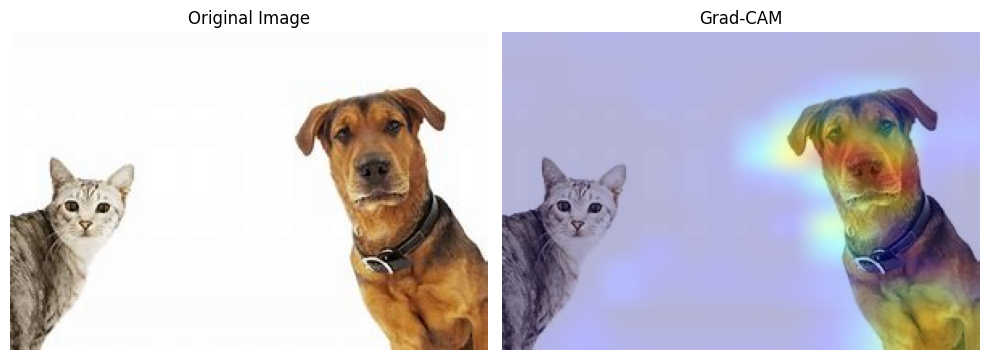

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
Predicted: Rhodesian_ridgeback


In [10]:
main()